## Final Activity 2

MegaTon Bank would like to gain insight on their customers. They aim to discover what type of saving plans, money management, loans, and other types of services they can recommend. For this, they collected the usage behavior and debt information of their active credit card holders. The debtData.csv dataset presents the attributes of credit card holders. This dataset can be used for customer segmentation to define a marketing strategy.

Create a clustering model for the given dataset. The dataset has the following columns:
- CustomerID
- Age
- EducationLevel
- YearsEmployed
- Income - in thousands per month
- CardDebt
- OtherDebt
- Defaulted - failed to pay the minimum payment of existing debt
- DebtIncomeRatio

CHECK THIS ARTICLE!

https://medium.com/@nirmalsankalana/k-means-clustering-choosing-optimal-k-process-and-evaluation-methods-2c69377a7ee4

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
raw = pd.read_csv('data/debtData.csv')

# Create a copy of the raw dataset
data = raw.copy()

# Handle missing values in 'Defaulted' by imputing with the mode
data['Defaulted'].fillna(1, inplace=True)

# Select features for clustering (exclude CustomerID)
data = data.drop('CustomerID', axis=1)
data = data.drop('DebtIncomeRatio', axis=1)

categorical_features = data[['EducationLevel', 'Defaulted']]

for col in ['Income', 'CardDebt', 'OtherDebt']:
    data[col] = np.log1p(data[col])  # log(x+1) to handle zeros

features = data[['Age', 'YearsEmployed', 'Income', 'CardDebt', 'OtherDebt']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Assign column names to the scaled features
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

data = pd.concat([categorical_features, scaled_features], axis=1)

data

,EducationLevel,Defaulted,Age,YearsEmployed,Income,CardDebt,OtherDebt
0,2,0.0,0.742915,-0.378790,-1.154930,-1.155634,-0.725413
1,1,0.0,1.489490,2.573721,1.628014,1.733823,1.657614
2,2,1.0,-0.252518,0.211712,0.674792,2.170302,1.172210
3,2,0.0,-0.750235,-0.674041,-1.154930,-0.429967,-1.225158
4,1,0.0,1.489490,3.311849,3.212853,2.839686,1.772895
...,...,...,...,...,...,...,...
845,1,1.0,-0.999093,-0.526415,-0.639196,-0.578573,-0.616000
846,2,0.0,-0.874664,-0.231164,-0.193222,-0.813340,-0.123986
847,4,1.0,-1.247951,-1.264543,-1.243079,1.041465,0.406029
848,1,0.0,-0.376947,0.506963,-0.516392,-1.168512,-1.045976


### WCSS
Optimal clusters are 2, 3, and 4. Further analysis and experimentation to be done to determine best.

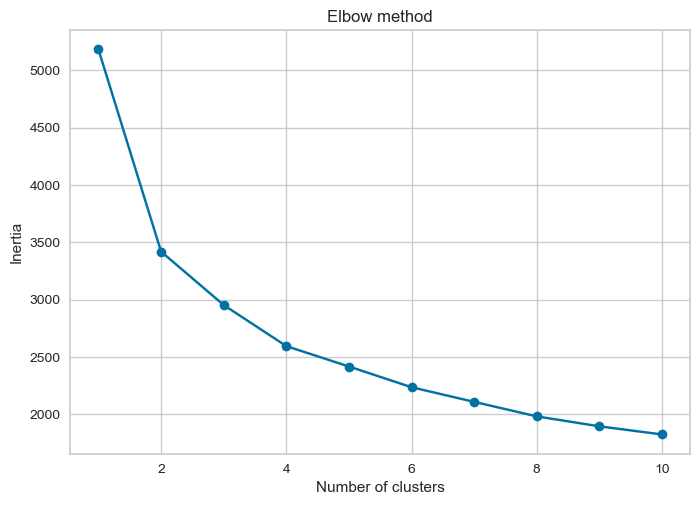

In [218]:
# Plot Elbow curve
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

### Silhouette Coefficient
According to silhouette coefficient 2 clusters is the most optimal count of clusters.

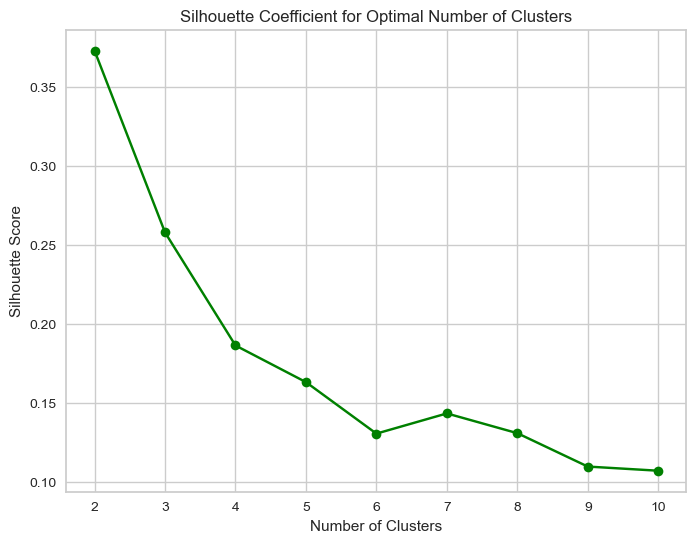

In [219]:
# Silhouette Coefficient
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    score = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(score)

# Plot Silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title('Silhouette Coefficient for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

### Silhouette Diagram for selected clusters
According to visualization of clusters 2, 3, and 4. 2 shows the highest silhouette score and most consistent distribution of values.

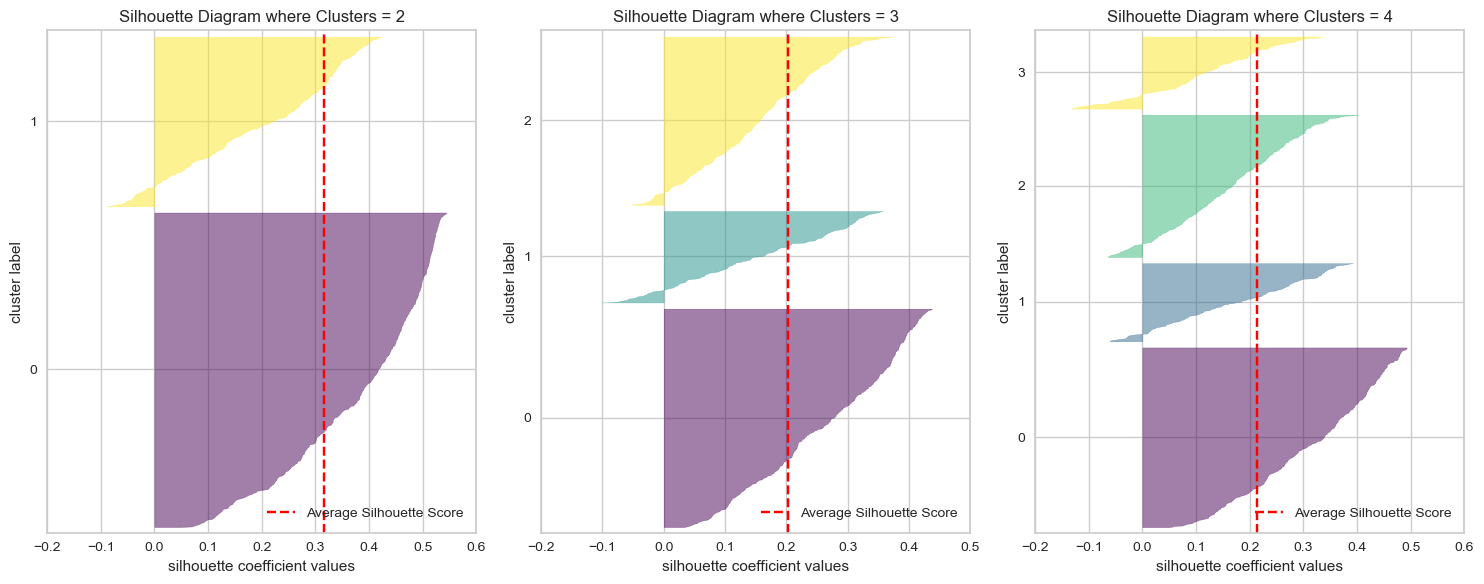

In [220]:
from yellowbrick.cluster import SilhouetteVisualizer

plt.figure(figsize=(15, 6))

# Create subplots for 2, 3, 4 clusters
for k in [2, 3, 4]:
    plt.subplot(1, 3, k-1)  # Positions: 1st, 2nd, 3rd subplot

    # Initialize visualizer with KMeans
    visualizer = SilhouetteVisualizer(
        KMeans(n_clusters=k, random_state=42),
        colors='viridis',
        ax=plt.gca(),
        title=f"Silhouette Diagram where Clusters = {k}"
    )

    # Fit and visualize
    visualizer.fit(data)
    visualizer.finalize()

plt.tight_layout()
plt.show()

### Use Principle Component Analysis
By visualizing the PCA of the clusters, it can be observed that the graph where cluster = 2 has the very minimal amount of overlapping and the separation of data points is very evident.

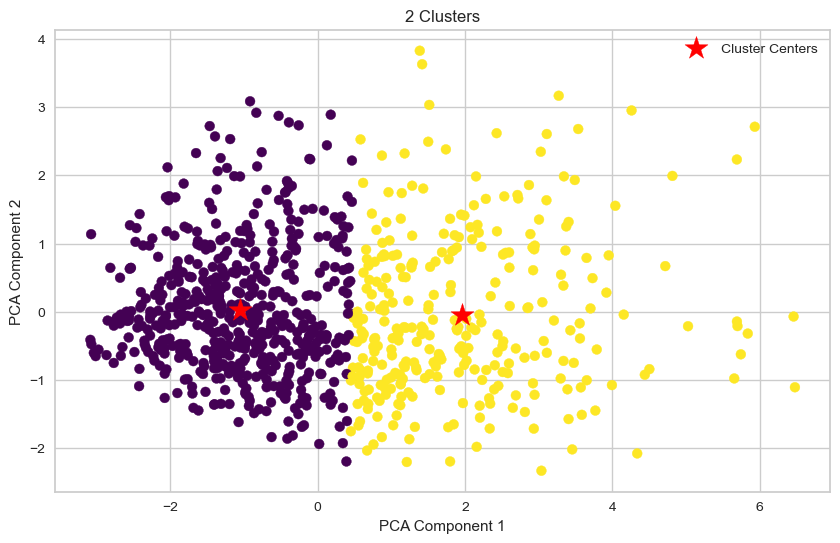

Silhouette Score for 2 clusters: 0.316


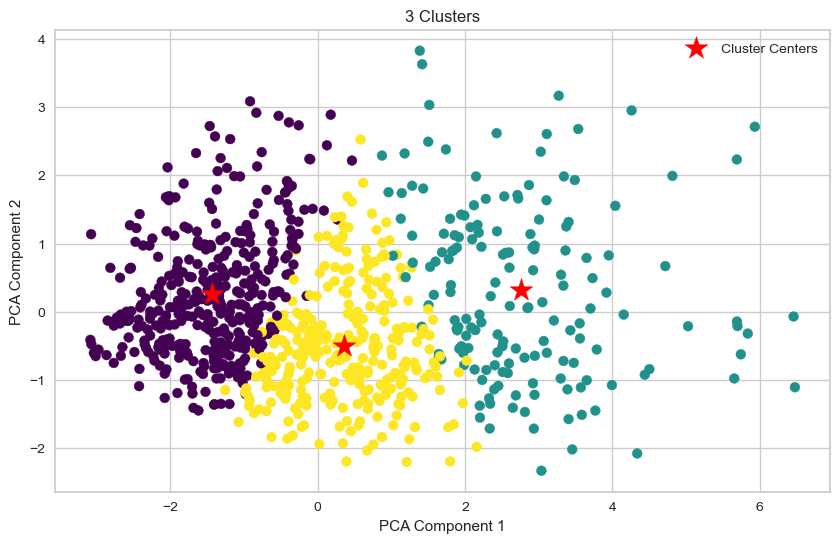

Silhouette Score for 3 clusters: 0.203


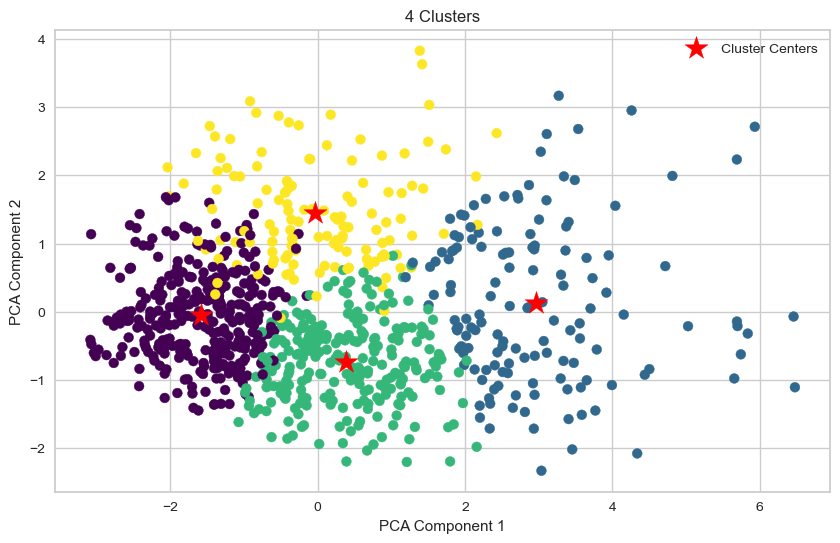

Silhouette Score for 4 clusters: 0.214


In [221]:
def evaluate_clusters(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, cluster_labels)

    # PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    centers_pca = pca.transform(kmeans.cluster_centers_)

    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
                s=300, c='red', marker='*', label='Cluster Centers')
    plt.title(f'{n_clusters} Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    return silhouette

for k in [2, 3, 4]:
    score = evaluate_clusters(k, data)
    print(f"Silhouette Score for {k} clusters: {score:.3f}")

### THE FINAL NUMBER OF CLUSTERS IS 2

### Train the Clustering Model

In [222]:
model_data = raw.copy()
# Create model where clusters=2
model_data = model_data.drop('CustomerID', axis=1)
model_data = model_data.drop('DebtIncomeRatio', axis=1)
clustering_model = KMeans(n_clusters=2, init='k-means++', random_state=42)
clustering_model.fit(data)

raw['Cluster'] = clustering_model.predict(data)

raw

,CustomerID,Age,EducationLevel,YearsEmployed,Income,CardDebt,OtherDebt,Defaulted,DebtIncomeRatio,Cluster
0,1,41,2,6,19,0.124,1.073,0.0,6.3,0
1,2,47,1,26,100,4.582,8.218,0.0,12.8,1
2,3,33,2,10,57,6.111,5.802,1.0,20.9,1
3,4,29,2,4,19,0.681,0.516,0.0,6.3,0
4,5,47,1,31,253,9.308,8.908,0.0,7.2,1
...,...,...,...,...,...,...,...,...,...,...
845,846,27,1,5,26,0.548,1.220,NaN,6.8,0
846,847,28,2,7,34,0.359,2.021,0.0,7.0,0
847,848,25,4,0,18,2.802,3.210,1.0,33.4,0
848,849,32,1,12,28,0.116,0.696,0.0,2.9,0


### Describe each Cluster

In [223]:
raw = raw.drop('CustomerID', axis=1)
# Group by cluster and calculate mean values
cluster_stats = raw.groupby('Cluster').mean()

# Calculate relative differences from overall mean
overall_mean = raw.mean(numeric_only=True)
cluster_comparison = cluster_stats.sub(overall_mean, axis=1)

print("Cluster Characteristics (Mean Values):")
display(cluster_stats)

print("\nDifference from Overall Mean:")
display(cluster_comparison)

Cluster Characteristics (Mean Values):


,Age,EducationLevel,YearsEmployed,Income,CardDebt,OtherDebt,Defaulted,DebtIncomeRatio
Cluster,,,,,,,,
0,31.605072,1.657609,5.253623,29.393116,0.796187,1.666350,0.274510,9.013768
1,41.372483,1.808725,14.701342,78.687919,3.022826,5.695074,0.236515,12.316443



Difference from Overall Mean:


,Age,CardDebt,Cluster,DebtIncomeRatio,Defaulted,EducationLevel,Income,OtherDebt,YearsEmployed
Cluster,,,,,,,,,
0,-3.424339,-0.780633,NaN,-1.157879,0.013081,-0.052980,-17.282178,-1.412423,-3.312259
1,6.343071,1.446006,NaN,2.144796,-0.024914,0.098137,32.012625,2.616301,6.135460


### Evaluation Metrics

Rand Index and Mutual Info is not included because there are no truth labels available for the dataset.

In [226]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

calhar_score = calinski_harabasz_score(data, raw['Cluster'])
davbo_score = davies_bouldin_score(data, raw['Cluster'])

print(f"Calinski-Harabasz Score: {calhar_score:.3f}")
print(f"Davies-Bouldin Score: {davbo_score:.3f}")

Calinski-Harabasz Score: 437.629
Davies-Bouldin Score: 1.306
